### Part One: Data Exploration
You can find this data at: https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1

Read in the dataset, and display some summaries of the data.

Fix any concerns you have about the data.

Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from plotnine import *

In [2]:
df = pd.read_csv("/Users/owenk/OneDrive/Documents/GitHub/GSB_544_ML/Lab 5/insurance_costs_1.csv")
df.head()

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,33,male,22.705,no,northwest,21984.47061
2,32,male,28.880,no,northwest,3866.85520
3,31,female,25.740,no,southeast,3756.62160
4,60,female,25.840,no,northwest,28923.13692


In [3]:
# dummify sex and smoker

enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(df[['sex']])

# Transform the species column into a one-hot encoded matrix
encoded_sex = enc.transform(df[['sex']]).toarray()

# Create a new DataFrame with the one-hot encoded species
encoded_sex_df = pd.DataFrame(encoded_sex, columns=enc.get_feature_names_out(['sex']))

# Concatenate the original DataFrame with the encoded species DataFrame
df3_encoded = pd.concat([df, encoded_sex_df], axis=1)

enc.fit(df[['smoker']])

encoded_smoker = enc.transform(df3_encoded[['smoker']]).toarray()

encoded_smoker_df = pd.DataFrame(encoded_smoker, columns=enc.get_feature_names_out(['smoker']))

insur_clean = pd.concat([df3_encoded, encoded_smoker_df], axis=1)

insur_clean = insur_clean.drop(['sex', 'smoker'], axis=1)
insur_clean.head()

,age,bmi,region,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,southwest,16884.92400,1.0,0.0,0.0,1.0
1,33,22.705,northwest,21984.47061,0.0,1.0,1.0,0.0
2,32,28.880,northwest,3866.85520,0.0,1.0,1.0,0.0
3,31,25.740,southeast,3756.62160,1.0,0.0,1.0,0.0
4,60,25.840,northwest,28923.13692,1.0,0.0,1.0,0.0


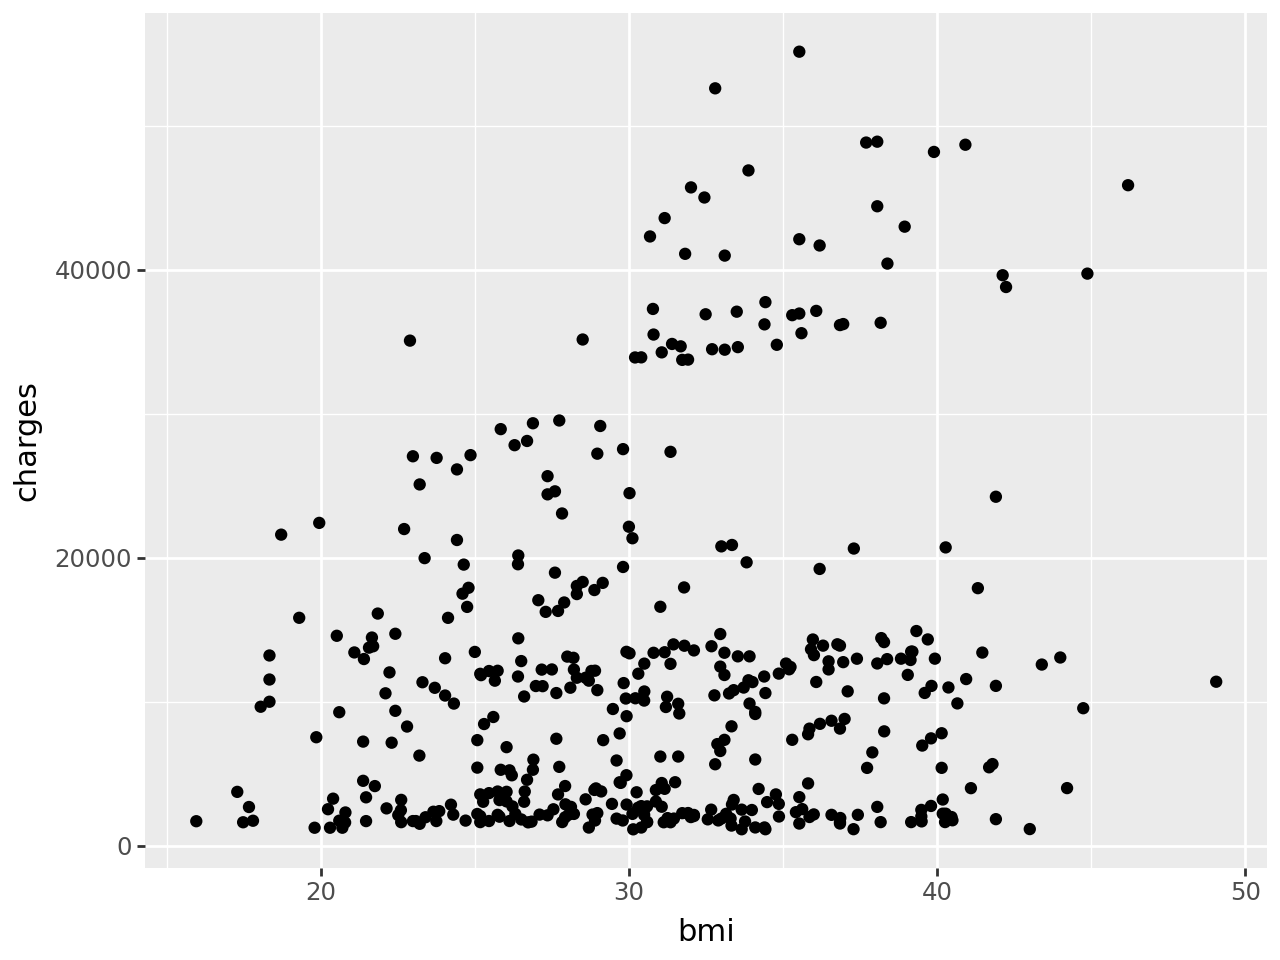

In [4]:
#See BMI relationship with charges
(ggplot(insur_clean, aes(x = 'bmi', y = 'charges'))
 + geom_point())

This plot shows the relationship between bmi and charges based on the dataset. The majority of the data points are clustered around 0 or minimal charges, but there appears to be a faint positive relationship between bmi and charges.

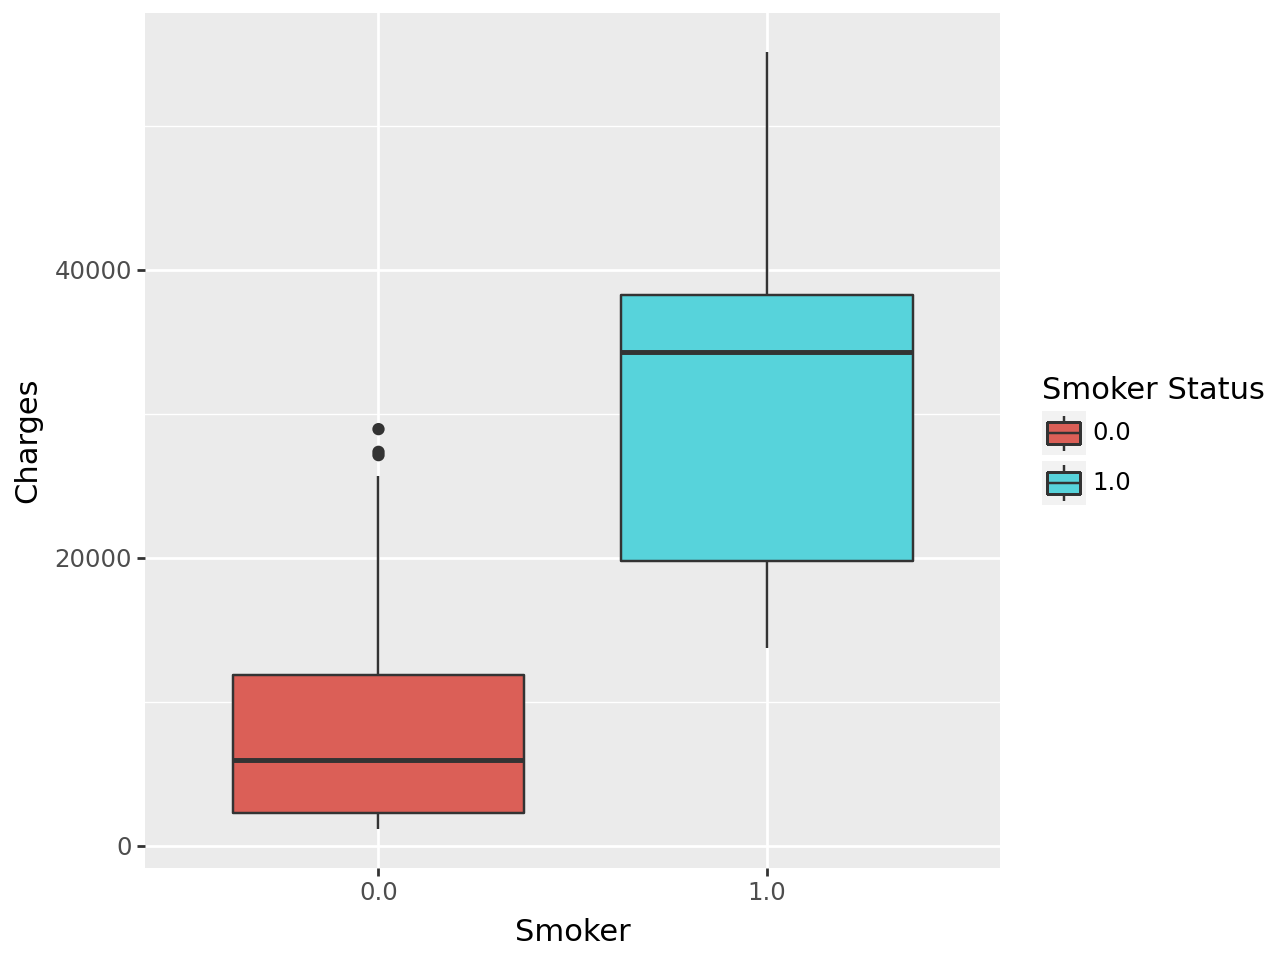

In [5]:
insur_clean['smoker_yes'] = insur_clean['smoker_yes'].astype('category')

(ggplot(insur_clean, aes(x = 'smoker_yes', y = 'charges', fill = 'smoker_yes'))
 + geom_boxplot()
 + labs(x = 'Smoker', y = 'Charges', fill = 'Smoker Status'))

Based on this boxplot, we can easily see that smokers have much higher charges than non-smokers. The quantiles also do not overlap, meaning that the 25 percentile of smokers pay more charges than the 75% percentile of non-smokers. 

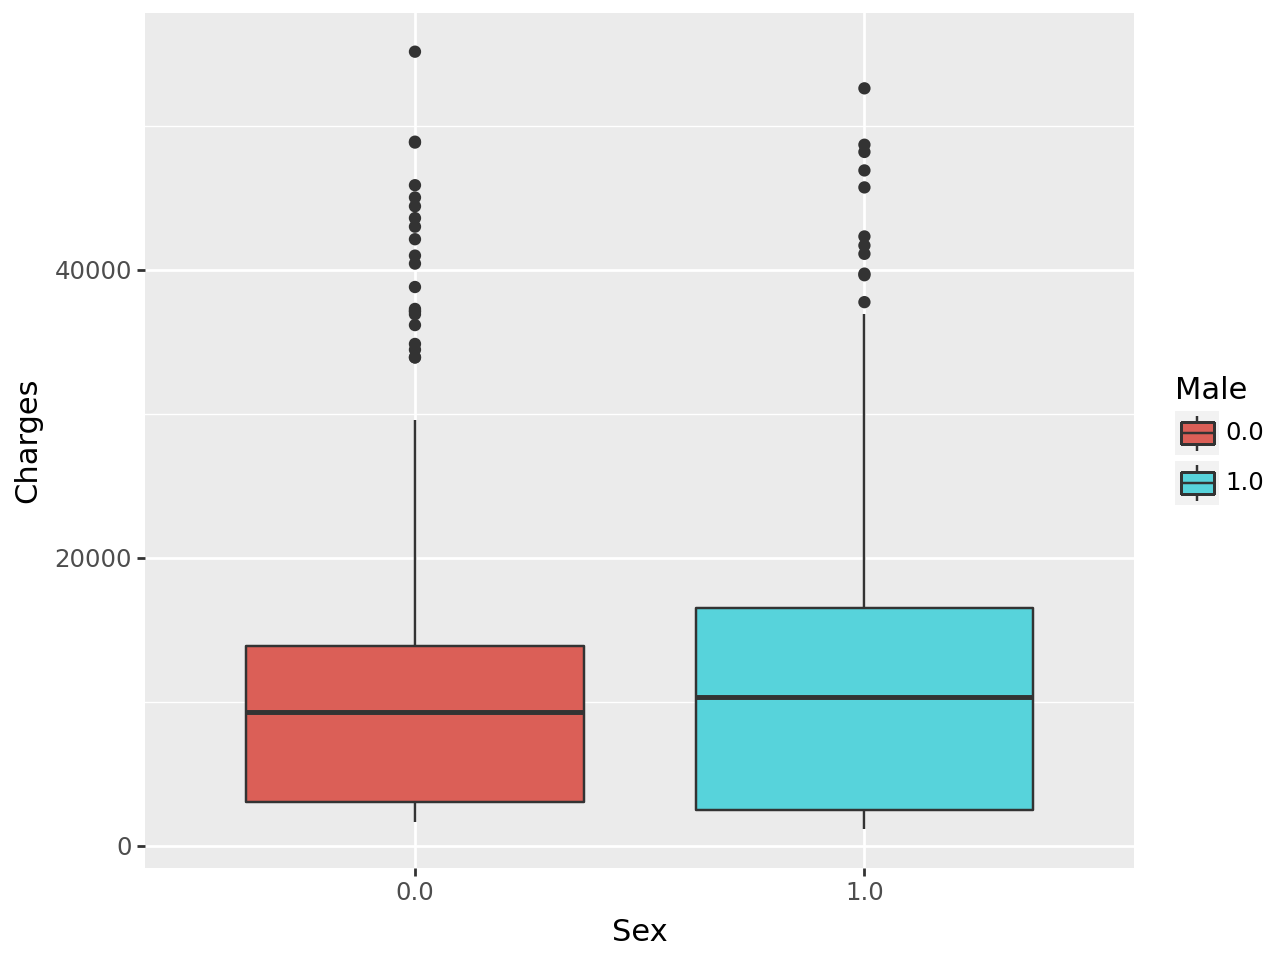

In [6]:
insur_clean['sex_male'] = insur_clean['sex_male'].astype('category')

(ggplot(insur_clean, aes(x = 'sex_male', y = 'charges', fill = 'sex_male'))
 + geom_boxplot()
 + labs(x = 'Sex', y = 'Charges', fill = 'Male'))

Based on the boxplot comparing sex to charges, there appears to be little difference in the the average charges that men pay vs women. However, Males do have a higher 75th percentile in charges than female, but this difference is negligle.

### Part Two: Simple Linear Models
Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

Make a model that also incorporates the variable sex. Report your results.

Now make a model that does not include sex, but does include smoker. Report your results.

Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.

In [7]:
#Model 1: age on insurance charges 
lr = LinearRegression()

X = insur_clean[['age']]
y = insur_clean['charges']

X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_fit1 = lr.fit(X_train, y_train)

train_preds1 = lr_fit1.predict(X_train)
test_preds1 = lr_fit1.predict(X_test)

print("Coefficients:", lr_fit1.coef_)
print("R^2:", r2_score(y_test, test_preds1))
print("MSE:", mean_squared_error(y_test, test_preds1))

Coefficients: [222.39592801]
R^2: 0.12309565345554052
MSE: 125926783.63983646


The coefficient of 262.1168 suggests that, on average, for every one-unit increase in age, the charges increase by approximately 262.12 units. However, our R^2 score suggests that the model is a poor fit, and that age does not explain any reasonable variation in insurance charges. The MSE also supports this, by showing that the model's predicted values vary beyond reason with the actual values. 

In [8]:
X2 = insur_clean[['age', 'sex_female']]
y2 = insur_clean['charges']

X2 = X2.dropna()
y2 = y2[X2.index]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

lr_fit2 = lr.fit(X2_train, y2_train)

train_preds2 = lr_fit2.predict(X2_train)
test_preds2 = lr_fit2.predict(X2_test)

print("Coefficients:", lr_fit2.coef_)
print("R^2:", r2_score(y2_test, test_preds2))
print("MSE:", mean_squared_error(y2_test, test_preds2))

Coefficients: [  229.69856671 -1351.1930196 ]
R^2: 0.08158435139091103
MSE: 117242779.63273276


The coefficient on sex_female shows that women tend to pay $650 less than males in insurance charges on average. However, the model only explains less than 5% of the variation in charges, and the MSE is significantly high, meaning that model is likely not a good fit for charges, and we can not predict charges based on age and sex alone. 

In [9]:
X3 = insur_clean[['age', 'smoker_yes']]
y3 = insur_clean['charges']

X3 = X3.dropna()
y3 = y3[X3.index]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2)

lr_fit3 = lr.fit(X3_train, y3_train)

train_preds3 = lr_fit3.predict(X3_train)
test_preds3 = lr_fit3.predict(X3_test)

print("Coefficients:", lr_fit3.coef_)
print("R^2:", r2_score(y3_test, test_preds3))
print("MSE:", mean_squared_error(y3_test, test_preds3))

Coefficients: [  264.50627728 24139.76806003]
R^2: 0.7230142574809784
MSE: 39479238.79233492


The coefficient on smoker_yes shows that, on average, smokers pay $2400 in charges more than non-smokers on average. The R^2 is .80, the highest of the 3 models, meaning that smoker designation explains 80% of the variation in insurance charges. The MSE is also the smallest of the 3 models, so the prediction varies less from the actual charge than the other models. Based on these models, model 3 fits the best based on R^2 score and MSE.

### Part Three: Multiple Linear Models
Now let’s consider including multiple quantitative predictors.

Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

In [10]:
#Model 4
X4 = insur_clean[['age', 'bmi']]
y4 = insur_clean['charges']

X4 = X4.dropna()
y4 = y4[X4.index]

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2)

lr_fit4 = lr.fit(X4_train, y4_train)

train_preds4 = lr_fit4.predict(X4_train)
test_preds4 = lr_fit4.predict(X4_test)

print("Coefficients:", lr_fit4.coef_)
print("R^2:", r2_score(y4_test, test_preds4))
print("MSE:", mean_squared_error(y4_test, test_preds4))

Coefficients: [231.37102733 279.04588015]
R^2: 0.06197379381583068
MSE: 111692134.23599912


The MSE in this model is significantly larger than the MSE in Part 2 Q1, meaning that the previous model is a better predictor of charges. The R^2 score is .13, meaning that this model captures only 13% of variation in charges. Compared to the previous model, this is low. 

Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

In [11]:
#Model 5
X5 = insur_clean[['age']].values.reshape(-1, 1)
y5 = insur_clean['charges']

poly = PolynomialFeatures(degree=2, include_bias=False)
X5_poly = poly.fit_transform(X5)

X5_train_poly, X5_test_poly, y5_train, y5_test = train_test_split(X5_poly, y5, test_size=0.2)

lr_fit5 = lr.fit(X5_train_poly, y5_train)

train_preds5 = lr_fit5.predict(X5_train_poly)
test_preds5 = lr_fit5.predict(X5_test_poly)

print("Coefficients:", lr_fit5.coef_)
print("R^2:", r2_score(y5_test, test_preds5))
print("MSE:", mean_squared_error(y5_test, test_preds5))

Coefficients: [373.76305031  -1.81239637]
R^2: 0.09758864495945552
MSE: 118775990.17046043


The MSE in this model is significantly larger than the MSE in Part 2 Q1, meaning that the previous model is a better predictor of charges. The R^2 score is .06, meaning that this model captures only 6% of variation in charges. This suggests that the relationship between age and charges is most likely not non-linear. . 

Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

In [12]:
#Model 6 
X6 = insur_clean[['age']].copy()

poly4 = PolynomialFeatures(degree=4, include_bias=False)
X6_poly = poly4.fit_transform(X6[['age']])

X6_train_poly, X6_test_poly, y6_train, y6_test = train_test_split(X6_poly, y, test_size=0.2)

lr_fit6 = lr.fit(X6_train_poly, y6_train)

train_preds6 = lr_fit6.predict(X6_train_poly)
test_preds6 = lr_fit6.predict(X6_test_poly)

print("Coefficients:", lr_fit6.coef_)
print("R^2:", r2_score(y6_test, test_preds6))
print("MSE:", mean_squared_error(y6_test, test_preds6))

Coefficients: [-5.32138915e+03  2.51720069e+02 -4.69686425e+00  3.07374642e-02]
R^2: 0.09286655024699764
MSE: 118342436.61105192


This model performs even worse than the previous 2 models, with a negative R^2 score on the test set, so the model is a very poor fit. This means that using age as a 4th degree polynomial predictor of charges does not capture the relationship. I would continue with the model constructed in PS Q1. 

Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

In [13]:
poly12 = PolynomialFeatures(degree=12, include_bias=False)
X7_poly = poly12.fit_transform(X6[['age']])

X7_train_poly, X7_test_poly, y7_train, y7_test = train_test_split(X7_poly, y, test_size=0.2)

lr_fit7 = lr.fit(X7_train_poly, y7_train)

train_preds7 = lr_fit7.predict(X7_train_poly)
test_preds7 = lr_fit7.predict(X7_test_poly)

pred7 = lr_fit7.predict(X7_poly) 

print("Coefficients:", lr_fit7.coef_)
print("R^2:", r2_score(y7_test, test_preds7))
print("MSE:", mean_squared_error(y7_test, test_preds7))

Coefficients: [-9.94748438e-10  3.12930847e-06 -6.89412606e-07 -1.14052408e-05
 -1.35754432e-04 -9.04093663e-04  1.13813952e-04 -5.80953767e-06
  1.55541495e-07 -2.31288375e-09  1.81496723e-11 -5.87959342e-14]
R^2: 0.05717038612700065
MSE: 163345043.71094915


This model performs the best out of the 3 previous models, however this does not neccessarily mean that this is the best model. Intuitively, a 12th degree polynomial of age is likely to overfit its relationship with nearly any dependent variable, including insurance charges, Based on the R^2 and MSE scores, I would prefer the model constructed in P2 Q1. 

Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

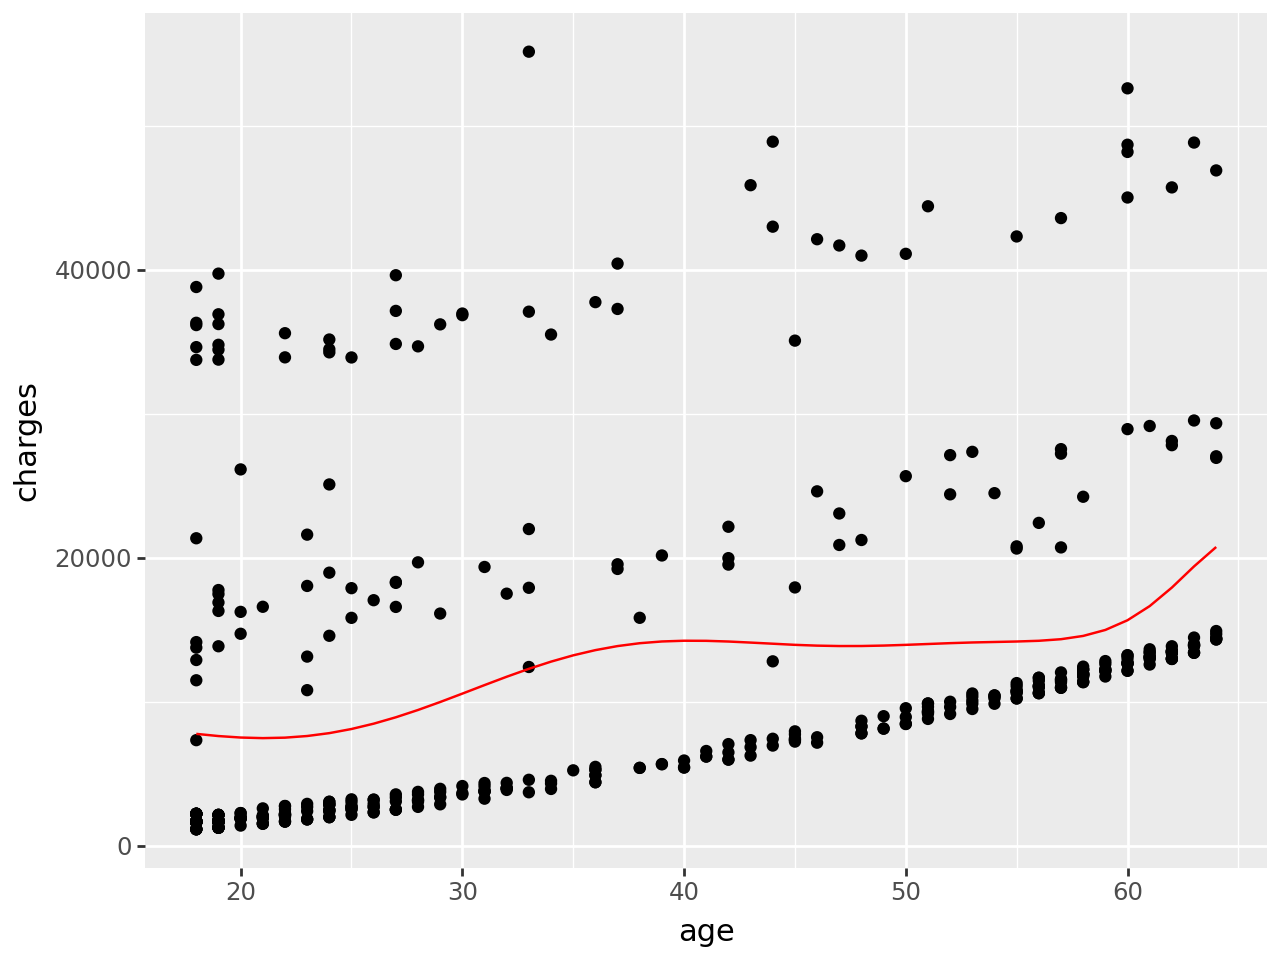

In [14]:
(ggplot(insur_clean, aes(x='age', y='charges'))
 + geom_point()
 + geom_line(aes(y = pred7), color = "red"))

### Part Four: New data
Great news! We’ve managed to collect data about the insurance costs for a few more individuals. You can find the new dataset here: https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1

Consider the following possible models:

1. Only age as a predictor.



In [15]:
new_data = pd.read_csv("/Users/owenk/OneDrive/Documents/GitHub/GSB_544_ML/insurance_costs_2.csv")
new_data.head()

,age,sex,bmi,smoker,region,charges
0,23,male,34.400,no,southwest,1826.84300
1,56,male,40.300,no,southwest,10602.38500
2,18,male,34.100,no,southeast,1137.01100
3,63,female,23.085,no,northeast,14451.83515
4,63,male,28.310,no,northwest,13770.09790


In [16]:
#Model 1 
X_new1 = new_data[['age']]
y_new = new_data['charges']

X1 = insur_clean[['age']]
y1 = insur_clean['charges']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)

lr_fit11 = lr.fit(X_train1, y_train1)

train_preds11 = lr_fit11.predict(X_train1)
test_preds11 = lr_fit11.predict(X_test1)

pred_new1 = lr_fit11.predict(X_new1)
print("MSE:", mean_squared_error(y_new, pred_new1))


MSE: 136376487.66592085


2. age and bmi as a predictor.



In [17]:
#Model 2
#lr_fit4: already fitted on original data 
X_new2 = new_data[['age', 'bmi']]

X41 = insur_clean[['age', 'bmi']]
y41 = insur_clean['charges']

X41_train, X41_test, y41_train, y41_test = train_test_split(X41, y41, test_size=0.2)

lr_fit41 = lr.fit(X41_train, y41_train)

train_preds41 = lr_fit41.predict(X41_train)
test_preds41 = lr_fit41.predict(X41_test)

pred_new2 = lr_fit41.predict(X_new2)
print("MSE:", mean_squared_error(y_new, pred_new2))

MSE: 132107647.20423692


3. age, bmi, and smoker as predictors (no interaction terms)



In [18]:
enc.fit(new_data[['smoker']])
encoded_smoker2 = enc.transform(new_data[['smoker']]).toarray()
encoded_smoker_df2 = pd.DataFrame(encoded_smoker2, columns=enc.get_feature_names_out(['smoker']))

new_data1 = pd.concat([new_data, encoded_smoker_df2], axis=1)
new_data1 = new_data1.drop(['smoker'], axis=1)

new_data1.head()


,age,sex,bmi,region,charges,smoker_no,smoker_yes
0,23,male,34.400,southwest,1826.84300,1.0,0.0
1,56,male,40.300,southwest,10602.38500,1.0,0.0
2,18,male,34.100,southeast,1137.01100,1.0,0.0
3,63,female,23.085,northeast,14451.83515,1.0,0.0
4,63,male,28.310,northwest,13770.09790,1.0,0.0


In [19]:
#Model 3
X8 = insur_clean[['age', 'bmi', 'smoker_yes']]
y8 = insur_clean['charges']

X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, test_size=0.2)

lr_fit8 = lr.fit(X8_train, y8_train)

train_preds8 = lr_fit8.predict(X8_train)
test_preds8 = lr_fit8.predict(X8_test)

X_new3 = new_data1[['age', 'bmi', 'smoker_yes']]

pred_new3 = lr_fit8.predict(X_new3)
print("MSE:", mean_squared_error(y_new, pred_new3))

MSE: 35012971.302737035


4. age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)

In [20]:
#Model 4
X9 = insur_clean[["age", "bmi", "smoker_yes"]]
y9 = insur_clean["charges"]

X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size=0.2, random_state=1)

ct_inter = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X9_train_poly = ct_inter.fit_transform(X9_train[["age", "bmi"]])
X9_test_poly = ct_inter.transform(X9_test[["age", "bmi"]])

#had issues with isolatingf the correct interaction terms, the following two chunks were referenced from a combiination of stack overflow and Chat GPT 4o. 
X9_train_poly_df = pd.DataFrame(X9_train_poly, columns=ct_inter.get_feature_names_out(input_features=["age", "bmi"]))
X9_train_final = pd.concat([X9_train_poly_df, X9_train["smoker_yes"].reset_index(drop=True)], axis=1)

#get_feature_names:generates column names for these transformed features, allowing X9_train_poly to be turned into a DataFrame 
X9_test_poly_df = pd.DataFrame(X9_test_poly, columns=ct_inter.get_feature_names_out(input_features=["age", "bmi"]))
X9_test_final = pd.concat([X9_test_poly_df, X9_test["smoker_yes"].reset_index(drop=True)], axis=1)

lr = LinearRegression()
lr_fit9 = lr.fit(X9_train_final, y9_train)

X_new4 = new_data1[['age', 'bmi']]
X_new_inter = ct_inter.transform(X_new4)

X_new_inter_df = pd.DataFrame(X_new_inter, columns=ct_inter.get_feature_names_out(input_features=["age", "bmi"]))
X_new_final = pd.concat([X_new_inter_df, new_data1["smoker_yes"].reset_index(drop=True)], axis=1)

predictions = lr_fit9.predict(X9_test_final)

pred_new4 = lr_fit9.predict(X_new_final)
print("MSE ", mean_squared_error(y_new, pred_new4))

print("Coefficients: ", lr_fit9.coef_)


MSE  35791971.78558144
Coefficients:  [1.90864493e+02 2.03742946e+02 1.26280675e+00 2.51468288e+04]


5. age, bmi, and smoker as predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)

In [21]:
#Model 5
X10 = insur_clean[["age", "bmi", "smoker_yes"]]
y10 = insur_clean["charges"]

X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size=0.2, random_state=1)

ct_inter1 = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

lr_pipeline = Pipeline([
    ("interactions", ct_inter1), 
    ("linear_regression", LinearRegression()) 
])

lr_fit10 = lr_pipeline.fit(X10_train, y10_train)

X9_test_inter = ct_inter1.transform(X10_test)
predictions = lr_fit10.predict(X10_test)

X_new4 = new_data1[['age', 'bmi', 'smoker_yes']]

pred_new4 = lr_fit10.predict(X_new4)

print("MSE: ", mean_squared_error(y_new, pred_new4))



MSE:  21844434.58816101


Based on this, which is the best model to use?

MSE 1: 136516636.62108114
MSE 2: 132283537.14750753
MSE 3: 35139707.56913951
MSE 4: 35791971.78558144
MSE 5: 21844434.58816101

Based on this, the best model to use is model 5, with age, bmi, and smoker as predictors, and interaction terms age*smoker and bmi*smoker.

Make a plot showing the residuals of your final chosen model.

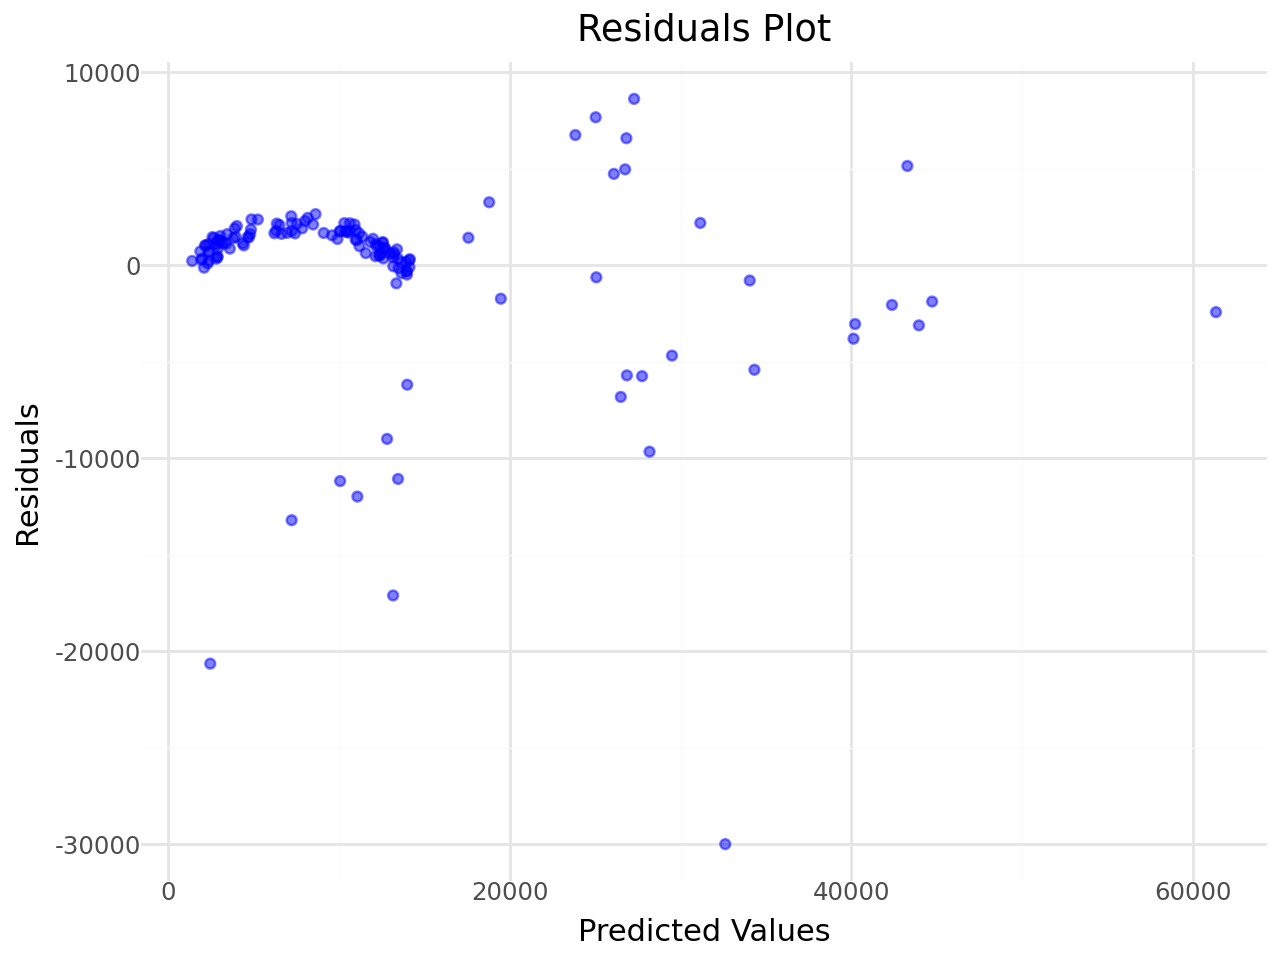

In [22]:
# Create the DataFrame for plotting
plot_df = pd.DataFrame({
    'Predicted': pred_new4,       
    'Residuals': pred_new4 - y_new  
})

(ggplot(plot_df, aes(x='Predicted', y='Residuals')) 
 + geom_point(color='blue', alpha=0.5) 
 + labs(title='Residuals Plot',
         x='Predicted Values',
         y='Residuals') 
 + theme_minimal() 
)



### Part Five: Full Exploration
Using any variables in this dataset, and any polynomial of those variables, find the model that best predicts on the new data after being fit on the original data.

Make a plot showing the residuals of your final chosen model.

In [34]:
#had to include this due to temporary transformations not saved when restarting kernal. 
insur_clean_encoded = pd.get_dummies(insur_clean, drop_first=True)

Xf = insur_clean_encoded.drop("charges", axis=1)
yf = insur_clean_encoded

#consider age and bmi specifically, due to our findings above, and being quantitative variables
ct_polyf = ColumnTransformer(
    [ 
        ("poly_age", PolynomialFeatures(), ["age"]),
        ("poly_bmi", PolynomialFeatures(), ["bmi"])
    ],
    remainder="passthrough"
)

lr_pipeline_poly = Pipeline(
    [("preprocessing", ct_polyf),
     ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

#limit to 10 degrees for reason
degrees = {
    'preprocessing__poly_age__degree': np.arange(1, 10),
    'preprocessing__poly_bmi__degree': np.arange(1, 10)
}

#scoring is r2, from above, despite the mean_test_score written below. Is mean of CV r2 scores
gscv = GridSearchCV(lr_pipeline_poly, degrees, cv=5, scoring='r2')

gscv_fitted = gscv.fit(Xf, yf)
parameters = pd.DataFrame(gscv_fitted.cv_results_["params"])

results_df = parameters.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

best_score_row = results_df.loc[results_df['scores'].idxmax()]
print(best_score_row)
print(best_score_row['scores'])

preprocessing__poly_age__degree    1.000000
preprocessing__poly_bmi__degree    3.000000
scores                             0.977934
Name: 2, dtype: float64
0.9779340729706252


In [35]:
Xf1 = insur_clean[["age", "bmi"]]
yf1 = insur_clean["charges"]

Xf1_train, Xf1_test, yf1_train, yf1_test = train_test_split(Xf1, yf1, test_size=0.2, random_state=1)

poly_age = PolynomialFeatures(degree=1, include_bias=False)
poly_bmi = PolynomialFeatures(degree=3, include_bias=False)

Xf1_train_age = poly_age.fit_transform(Xf1_train[['age']])
Xf1_train_bmi = poly_bmi.fit_transform(Xf1_train[['bmi']])

Xf1_train_transformed = np.concatenate([Xf1_train_age, Xf1_train_bmi], axis=1)

lr = LinearRegression()
lr_fitf1 = lr.fit(Xf1_train_transformed, yf1_train)

Xf1_test_age = poly_age.transform(Xf1_test[['age']])
Xf1_test_bmi = poly_bmi.transform(Xf1_test[['bmi']])

Xf1_test_transformed = np.concatenate([Xf1_test_age, Xf1_test_bmi], axis=1)

predictions = lr.predict(Xf1_test_transformed)

mse_test = mean_squared_error(yf1_test, predictions)

X_newf1 = new_data1[['age', 'bmi']] 

X_newf1_age = poly_age.transform(X_newf1[['age']])
X_newf1_bmi = poly_bmi.transform(X_newf1[['bmi']])

X_newf1_transformed = np.concatenate([X_newf1_age, X_newf1_bmi], axis=1)

pred_newf1 = lr.predict(X_newf1_transformed)

print("MSE: ", mean_squared_error(y_new, pred_newf1))


MSE:  134346171.68909588


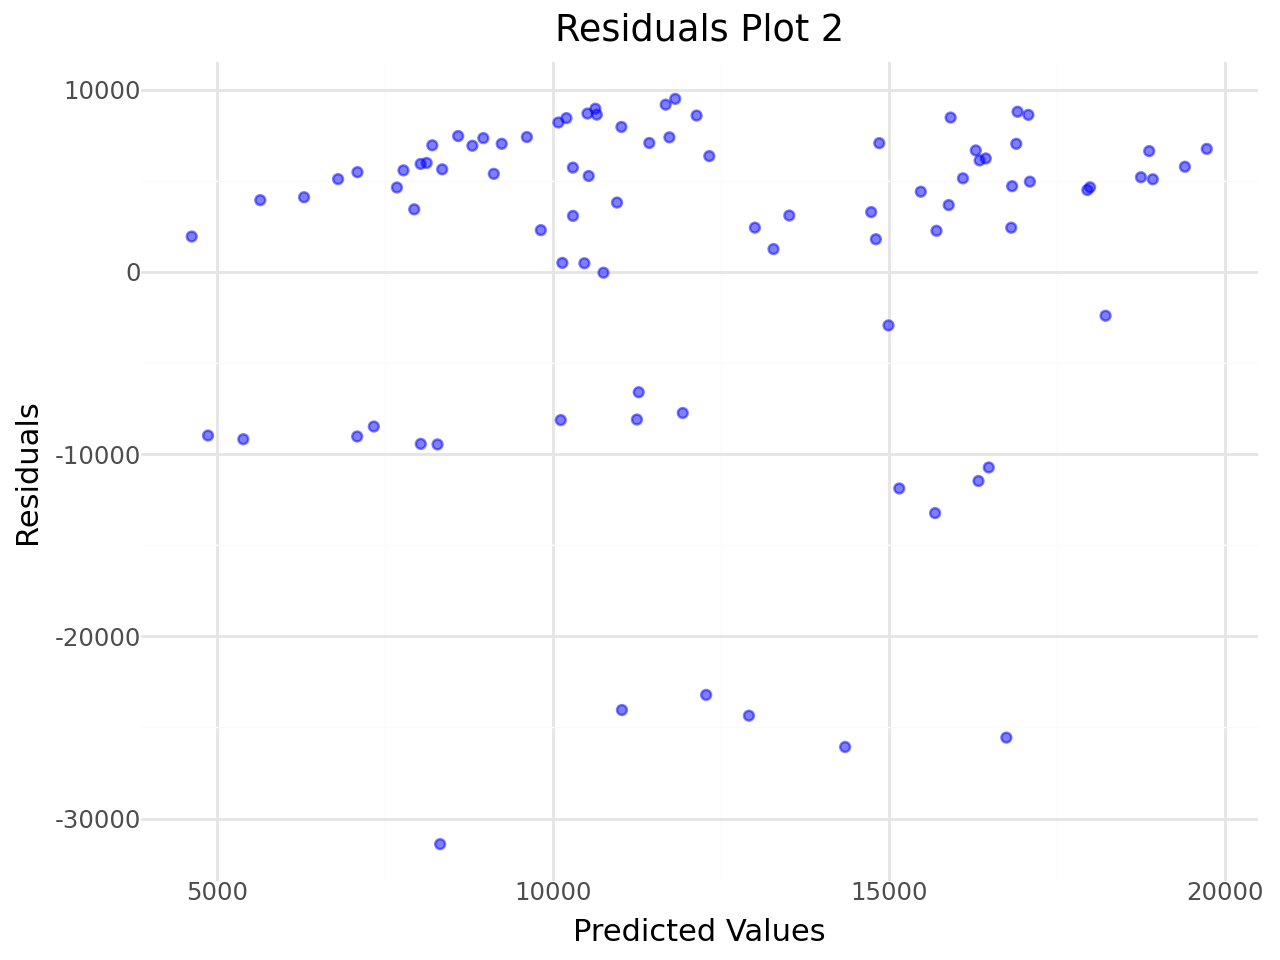

In [36]:
plot_df1 = pd.DataFrame({
    'Actual': yf1_test,
    'Predicted': predictions,
    'Residuals': predictions - yf1_test 
})

(ggplot(plot_df1, aes(x='Predicted', y='Residuals')) 
 + geom_point(color='blue', alpha=0.5) 
 + labs(title='Residuals Plot 2',
    x='Predicted Values',
    y='Residuals') 
 + theme_minimal())